In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt;
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_excel("/content/PNJ_stock_data.xlsx")

In [ ]:
df

,DATE,Close
0,2021-07-01,960000
1,2021-07-02,970000
2,2021-07-03,969000
3,2021-07-04,958000
4,2021-07-05,958000
...,...,...
57,2021-08-27,842000
58,2021-08-28,842000
59,2021-08-29,846000
60,2021-08-30,849000


In [ ]:
df.index = pd.to_datetime(df.DATE, format='%Y-%m-%d')

In [ ]:
df_numeric = df.select_dtypes(include='number')
df_resampled = df_numeric.resample("d").sum()

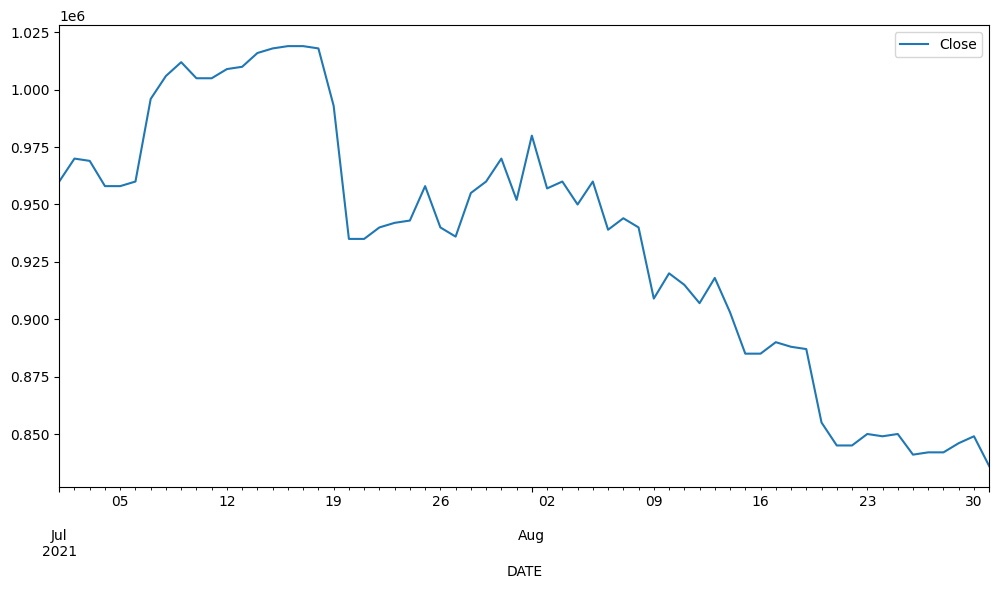

In [ ]:
df_resampled.plot(figsize=(12,6));

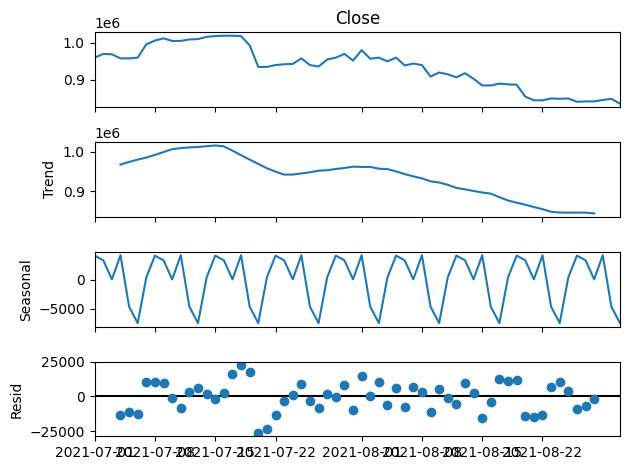

In [ ]:
results = seasonal_decompose(df_resampled['Close'])
results.plot();

In [ ]:
train = df_resampled[:-30]
test = df_resampled[-30:]

In [ ]:
train.head()

,Close
DATE,
2021-07-01,960000
2021-07-02,970000
2021-07-03,969000
2021-07-04,958000
2021-07-05,958000


In [ ]:
test.head()

,Close
DATE,
2021-08-02,957000
2021-08-03,960000
2021-08-04,950000
2021-08-05,960000
2021-08-06,939000


In [ ]:
def generate_lag(df, n):
    X, y = [], []
    for i in range(len(df) - n):
        X.append(df[i:i+n])
        y.append(df[n+i])

    return np.array(X), np.array(y), np.array(y[-n:]).reshape(1,n)

In [ ]:
X, y, last_batch_values = generate_lag(train.Close.values, 12)

In [ ]:
X

array([[ 960000,  970000,  969000,  958000,  958000,  960000,  996000,
        1006000, 1012000, 1005000, 1005000, 1009000],
       [ 970000,  969000,  958000,  958000,  960000,  996000, 1006000,
        1012000, 1005000, 1005000, 1009000, 1010000],
       [ 969000,  958000,  958000,  960000,  996000, 1006000, 1012000,
        1005000, 1005000, 1009000, 1010000, 1016000],
       [ 958000,  958000,  960000,  996000, 1006000, 1012000, 1005000,
        1005000, 1009000, 1010000, 1016000, 1018000],
       [ 958000,  960000,  996000, 1006000, 1012000, 1005000, 1005000,
        1009000, 1010000, 1016000, 1018000, 1019000],
       [ 960000,  996000, 1006000, 1012000, 1005000, 1005000, 1009000,
        1010000, 1016000, 1018000, 1019000, 1019000],
       [ 996000, 1006000, 1012000, 1005000, 1005000, 1009000, 1010000,
        1016000, 1018000, 1019000, 1019000, 1018000],
       [1006000, 1012000, 1005000, 1005000, 1009000, 1010000, 1016000,
        1018000, 1019000, 1019000, 1018000,  993000],


In [ ]:
y

array([1010000, 1016000, 1018000, 1019000, 1019000, 1018000,  993000,
        935000,  935000,  940000,  942000,  943000,  958000,  940000,
        936000,  955000,  960000,  970000,  952000,  980000])

In [ ]:
last_batch_values

array([[935000, 940000, 942000, 943000, 958000, 940000, 936000, 955000,
        960000, 970000, 952000, 980000]])

In [ ]:
def mlp_model(input_, y_, epochs=1000):
    model = Sequential()
    model.add(Dense(100, activation='relu', input_dim=input_.shape[1]))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.fit(input_, y_, epochs=epochs))
    return model

In [ ]:
model = mlp_model(X,y, epochs=3000)
model

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 10ms/step - loss: 863862656.0000
Epoch 502/3000
1/1 [==============================] - 0s 9ms/step - loss: 863727296.0000
Epoch 503/3000
1/1 [==============================] - 0s 10ms/step - loss: 863592064.0000
Epoch 504/3000
1/1 [==============================] - 0s 9ms/step - loss: 863458688.0000
Epoch 505/3000
1/1 [==============================] - 0s 11ms/step - loss: 863322816.0000
Epoch 506/3000
1/1 [==============================] - 0s 14ms/step - loss: 863186240.0000
Epoch 507/3000
1/1 [==============================] - 0s 11ms/step - loss: 863051584.0000
Epoch 508/3000
1/1 [==============================] - 0s 10ms/step - loss: 862916096.0000
Epoch 509/3000
1/1 [==============================] - 0s 10ms/step - loss: 862780416.0000
Epoch 510/3000
1/1 [==============================] - 0s 10ms/step - loss: 862645888.0000
Epoch 511/3000
1/1 [==============================] - 0s 10ms/step

In [ ]:
def forecast_function(model, last_batch, n):
    in_value = last_batch.copy()
    preds = []
    for i in range(n):
        p = model.predict(in_value)
        preds.append(p.ravel())
        in_value = np.append(in_value, p)[1:].reshape(last_batch.shape)
    return np.array(preds).ravel()

In [ ]:
pred = forecast_function(model, last_batch_values, 30)

1/1 [==============================] - 0s 22ms/step


In [ ]:
pred

array([964637.9 , 963415.44, 963630.4 , 965234.75, 953174.56, 951101.75,
       950625.94, 949451.25, 943421.94, 942132.2 , 943630.94, 938957.5 ,
       937790.44, 938435.5 , 936922.06, 933244.  , 932439.9 , 931748.8 ,
       929629.6 , 926914.4 , 925926.1 , 924196.44, 921589.25, 920148.7 ,
       919008.  , 916855.4 , 914699.56, 913396.06, 911924.  , 909964.  ],
      dtype=float32)

In [ ]:
test['Predicted_Close_Value']=pred

In [ ]:
test.head()

,Close,Predicted_Close_Value
DATE,,
2021-08-02,957000,964637.8750
2021-08-03,960000,963415.4375
2021-08-04,950000,963630.3750
2021-08-05,960000,965234.7500
2021-08-06,939000,953174.5625


<Axes: xlabel='DATE'>

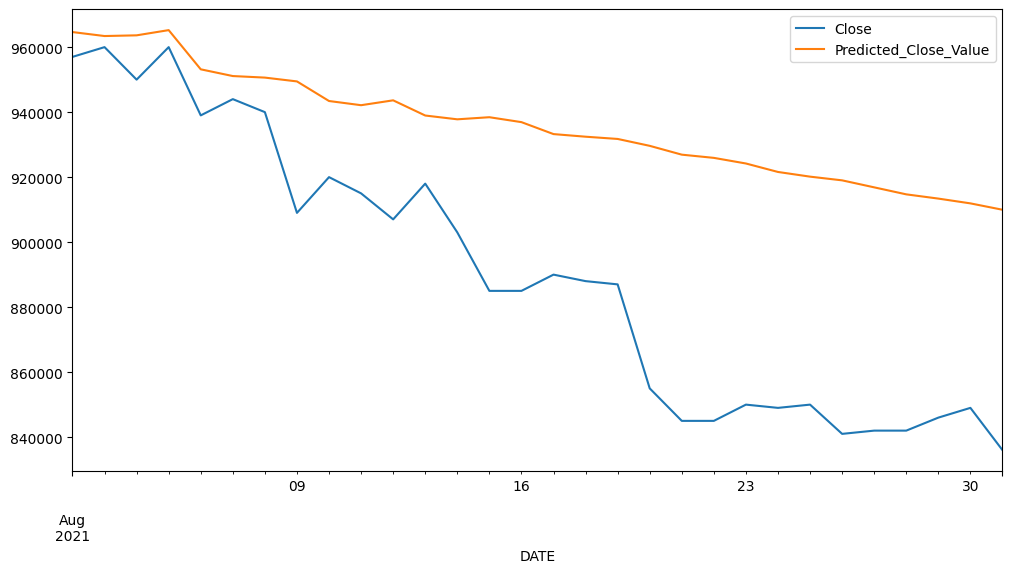

In [ ]:
test.plot(figsize=(12,6))

In [ ]:
def error_function(df,column_1,column_2):
    data = df.copy()
    my_list = []
    for i in range(len(data)):
        x = (data[column_2][i]*100)/data[column_1][i]
        if x >= 100:
            error = x-100
            #data['error_percentage'][i] = error
            my_list.append(error)
        else:
            error = 100-x
            my_list.append(error)
            #data['error_percentage'][i] = error
    data['error_percentage'] = my_list
    return data

In [ ]:
column_1 = 'Close'
column_2 = 'Predicted_Close_Value'
df_new = error_function(test,column_1,column_2)

In [ ]:
df_new

,Close,Predicted_Close_Value,error_percentage
DATE,,,
2021-08-02,957000,964637.8750,0.798106
2021-08-03,960000,963415.4375,0.355775
2021-08-04,950000,963630.3750,1.434776
2021-08-05,960000,965234.7500,0.545286
2021-08-06,939000,953174.5625,1.509538
2021-08-07,944000,951101.7500,0.752304
2021-08-08,940000,950625.9375,1.130419
2021-08-09,909000,949451.2500,4.450083
2021-08-10,920000,943421.9375,2.545863


In [ ]:
def mean_error(df,error_column):
    total = 0
    for i in range(len(df)):
        total += df[error_column][i]
    mean_error_ = total/(len(df))
    return mean_error_

In [ ]:
error_rate = mean_error(df_new,'error_percentage')

In [ ]:
error_rate

5.267723300035963

In [ ]:
sum_of_actual_Close = sum(df_new.Close.values)

In [ ]:
sum_of_actual_Close

26707000

In [ ]:
sum_of_predicted_Close = sum(df_new.Predicted_Close_Value.values)

In [ ]:
sum_of_predicted_Close

28074246.6875

In [ ]:
rate_of_actual_and_predict_sums = (sum_of_predicted_Close*100)/sum_of_actual_Close

In [ ]:
if rate_of_actual_and_predict_sums >= 100:
    total_percentage = rate_of_actual_and_predict_sums - 100
else:
    total_percentage = 100-rate_of_actual_and_predict_sums

In [ ]:
print('Percentage error: ',total_percentage)

Percentage error:  5.119431937319803
